In [17]:
import random
import numpy as np
from importlib import reload

In [18]:
import int_to_board
reload(int_to_board)

<module 'int_to_board' from 'C:\\Users\\Danie\\PycharmProjects\\patterns\\int_to_board.py'>

In [19]:
import int_to_board
reload(int_to_board)

import game
reload(game)

import plotting
reload(plotting)

from game import Patterns
from plotting import PatternPlotter

random.seed(1273894)

Turn 1, for Player 1
Score is currently:
Player 1: 0 -- 0: Player 2
Available actions are: 
[104, 105, 106]
action taken is: 105


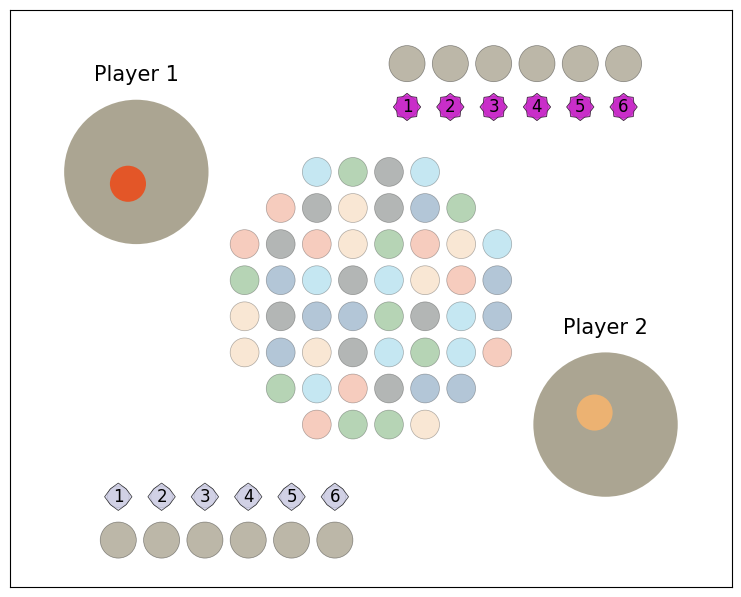

Turn 2, for Player 2
Score is currently:
Player 1: 0 -- 0: Player 2
Available actions are: 
[26, 22, 29, 19, 25, 38, 32, 35, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 18, 31, 21, 34, 40, 24, 37, 14, 5, 2, 11, 17, 8, 42, 45, 49, 20, 27, 33, 23, 36, 30, 39, 4, 1, 10, 7, 13, 16, 48, 47, 51, 44]
action taken is: 27
Color: 0
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (3, 0), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (2, 4), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (7, 3), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (1, 4), (2, 3), (2, 6), (7, 2), (6, 6), (7, 5), (6, 3)}
Passive flipping groups: {(4, 0)}
Passive placing groups: {(3, 1), (4, 0), (5, 1), (4, 2)}



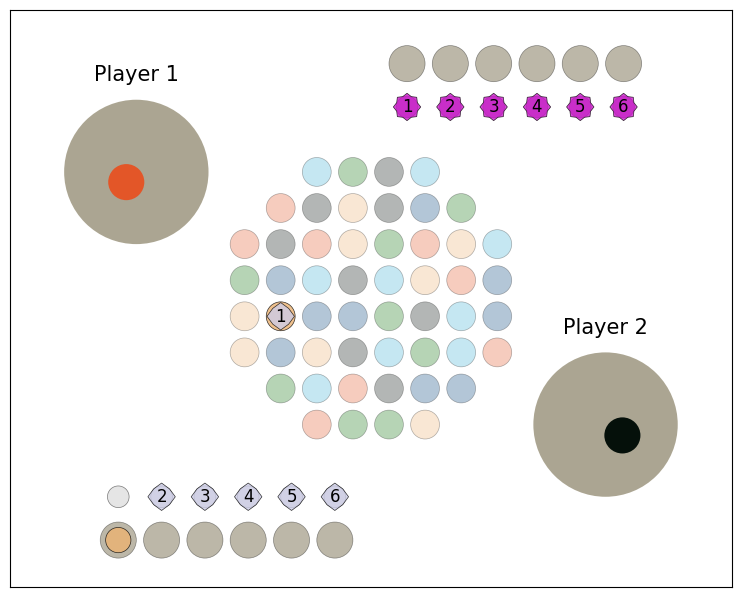

Turn 3, for Player 1
Score is currently:
Player 1: 0 -- 1: Player 2
Available actions are: 
[26, 22, 29, 19, 25, 38, 32, 35, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 18, 31, 21, 34, 40, 24, 37, 14, 5, 2, 11, 17, 8, 42, 45, 49, 20, 33, 23, 36, 30, 39, 4, 1, 10, 7, 13, 16, 48, 47, 51, 44]
action taken is: 7
Color: 0
Active flipping groups: {(4, 0)}
Active placing groups: {(3, 1), (4, 0), (5, 1), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (3, 0), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (2, 4), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (7, 3), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (2, 6), (7, 2), (6, 6), (7, 5), (6, 3)}

Color: 1
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (0, 

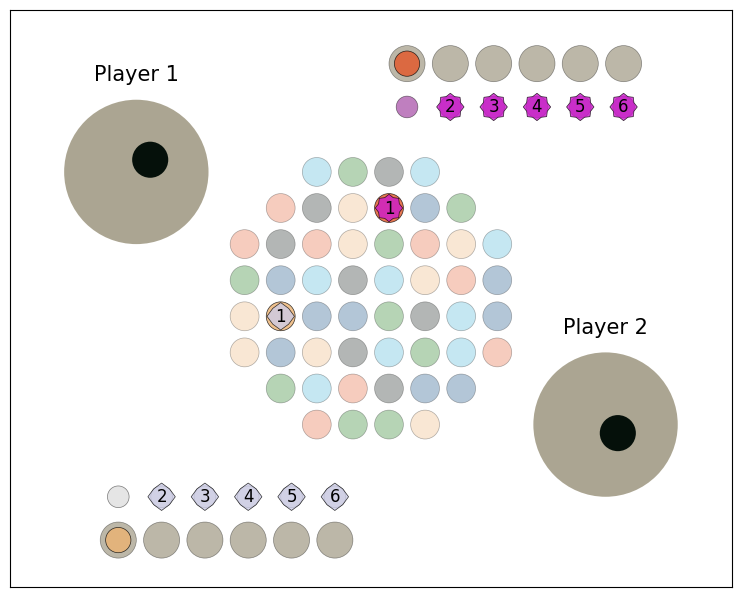

Turn 4, for Player 2
Score is currently:
Player 1: 1 -- 1: Player 2
Available actions are: 
[26, 22, 29, 19, 25, 38, 32, 35, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 18, 31, 21, 34, 40, 24, 37, 14, 5, 2, 11, 17, 8, 42, 45, 49, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 16, 48, 47, 51, 44, 78]
action taken is: 14
Color: 0
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (3, 0), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (7, 3), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (2, 6), (7, 2), (6, 6), (7, 5), (6, 3)}
Passive flipping groups: {(4, 0)}
Passive placing groups: {(3, 1), (4, 0), (5, 1), (4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(4

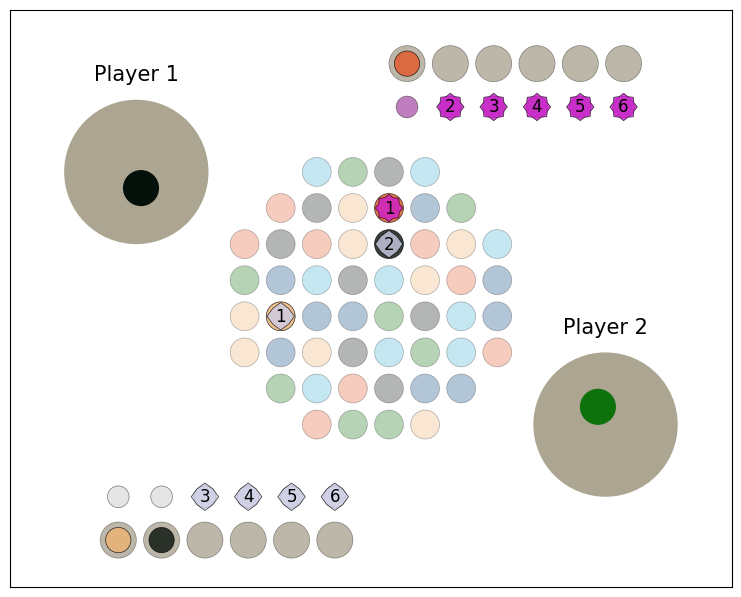

Turn 5, for Player 1
Score is currently:
Player 1: 1 -- 3: Player 2
Available actions are: 
[26, 22, 29, 19, 25, 38, 32, 35, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 18, 31, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 49, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 16, 48, 47, 51, 44]
action taken is: 49
Color: 0
Active flipping groups: {(4, 0)}
Active placing groups: {(3, 1), (4, 0), (5, 1), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (3, 0), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (2, 6), (7, 2), (6, 6), (7, 5), (6, 3)}

Color: 1
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1

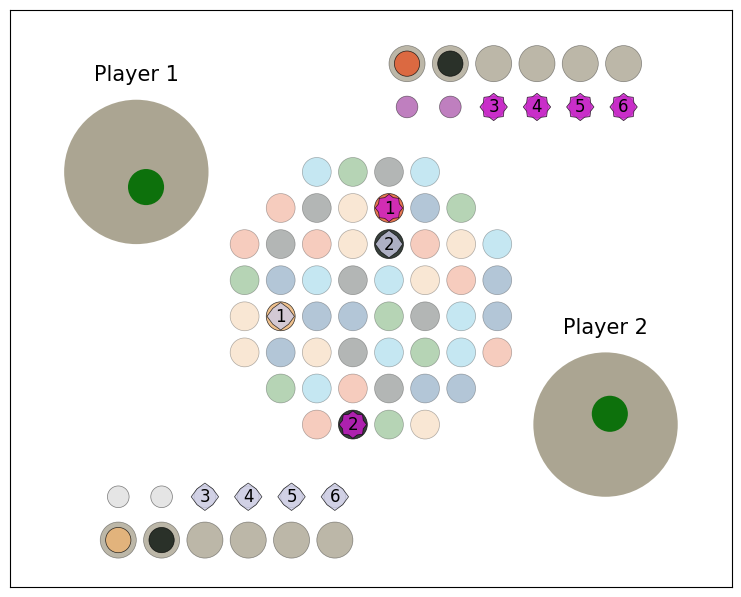

Turn 6, for Player 2
Score is currently:
Player 1: 3 -- 3: Player 2
Available actions are: 
[26, 22, 29, 19, 25, 38, 32, 35, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 18, 31, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 16, 48, 47, 51, 44, 78]
action taken is: 18
Color: 0
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (2, 6), (7, 2), (6, 6), (7, 5), (6, 3)}
Passive flipping groups: {(4, 0)}
Passive placing groups: {(3, 1), (4, 0), (5, 1), (4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3

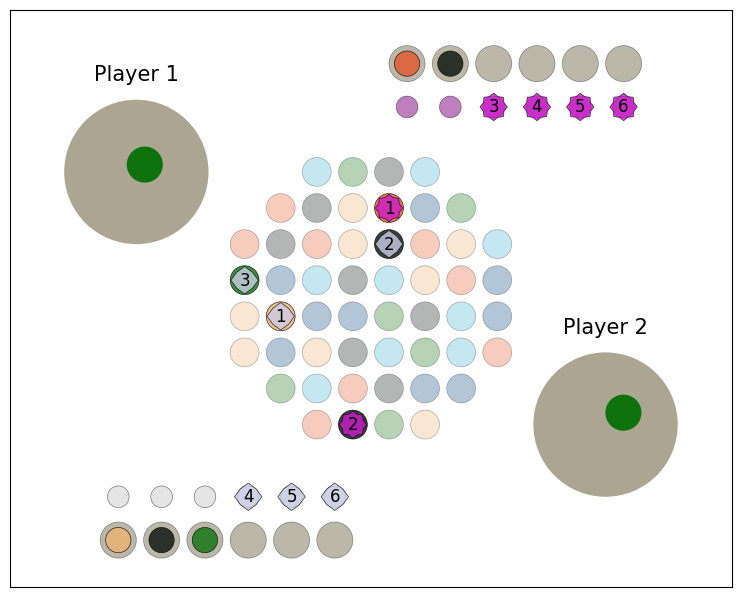

Turn 7, for Player 1
Score is currently:
Player 1: 3 -- 6: Player 2
Available actions are: 
[26, 22, 29, 19, 25, 38, 32, 35, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 31, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 16, 48, 47, 51, 44]
action taken is: 32
Color: 0
Active flipping groups: {(4, 0)}
Active placing groups: {(3, 1), (4, 0), (5, 1), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (2, 6), (7, 2), (6, 6), (7, 5), (6, 3)}

Color: 1
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (5, 4), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6

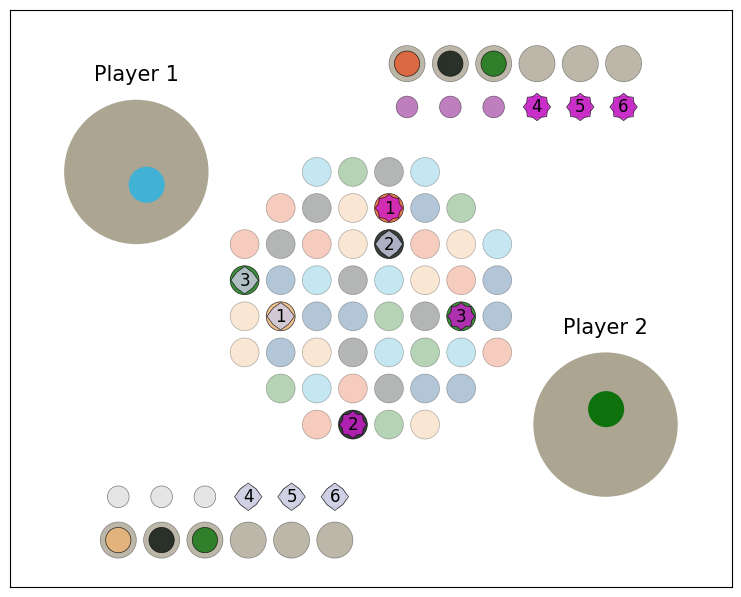

Turn 8, for Player 2
Score is currently:
Player 1: 6 -- 6: Player 2
Available actions are: 
[19, 26, 10, 78]
action taken is: 19
Color: 0
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (2, 6), (7, 2), (6, 6), (7, 5), (6, 3)}
Passive flipping groups: {(4, 0)}
Passive placing groups: {(4, 0), (5, 1), (4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 1), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5

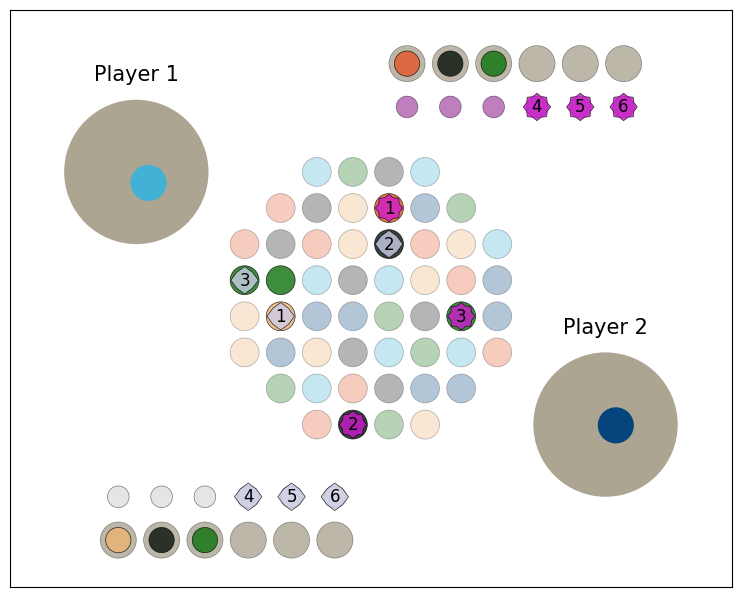

Turn 9, for Player 1
Score is currently:
Player 1: 6 -- 9: Player 2
Available actions are: 
[26, 22, 29, 25, 38, 35, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 31, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 16, 48, 47, 51, 44]
action taken is: 35
Color: 0
Active flipping groups: {(4, 0)}
Active placing groups: {(4, 0), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (2, 6), (7, 2), (6, 6), (7, 5), (6, 3)}

Color: 1
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3

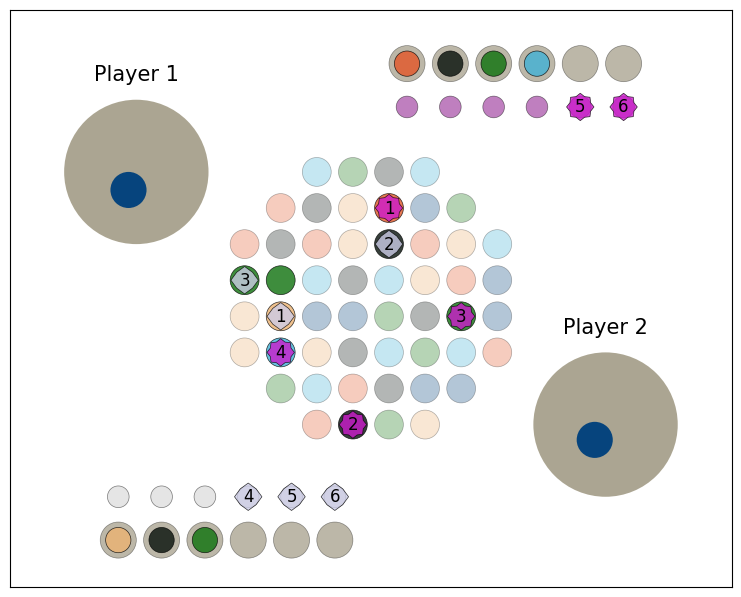

Turn 10, for Player 2
Score is currently:
Player 1: 10 -- 9: Player 2
Available actions are: 
[26, 22, 29, 25, 38, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 31, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 16, 48, 47, 51, 44, 78]
action taken is: 48
Color: 0
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (2, 6), (6, 6), (7, 5), (6, 3)}
Passive flipping groups: {(4, 0)}
Passive placing groups: {(4, 0), (4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), 

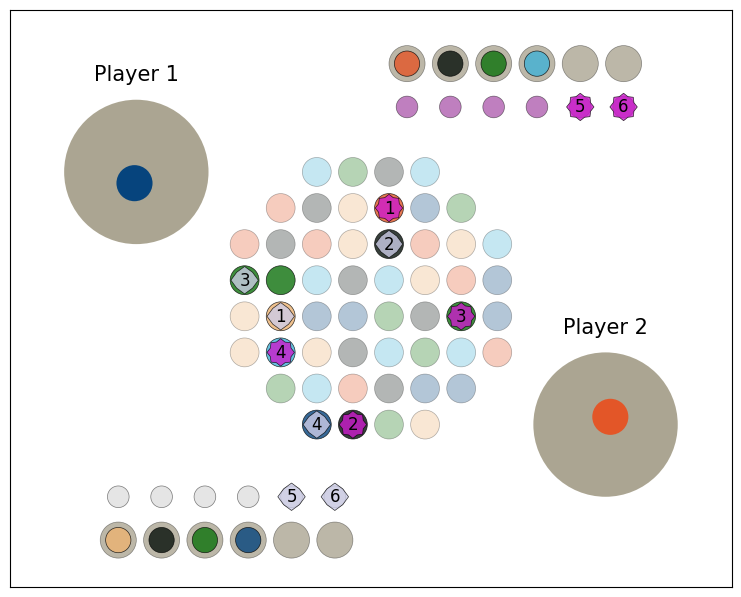

Turn 11, for Player 1
Score is currently:
Player 1: 10 -- 13: Player 2
Available actions are: 
[26, 22, 29, 25, 38, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 31, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 16, 47, 51, 44]
action taken is: 16
Color: 0
Active flipping groups: {(4, 0)}
Active placing groups: {(4, 0), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (6, 6), (7, 5), (6, 3)}

Color: 1
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2),

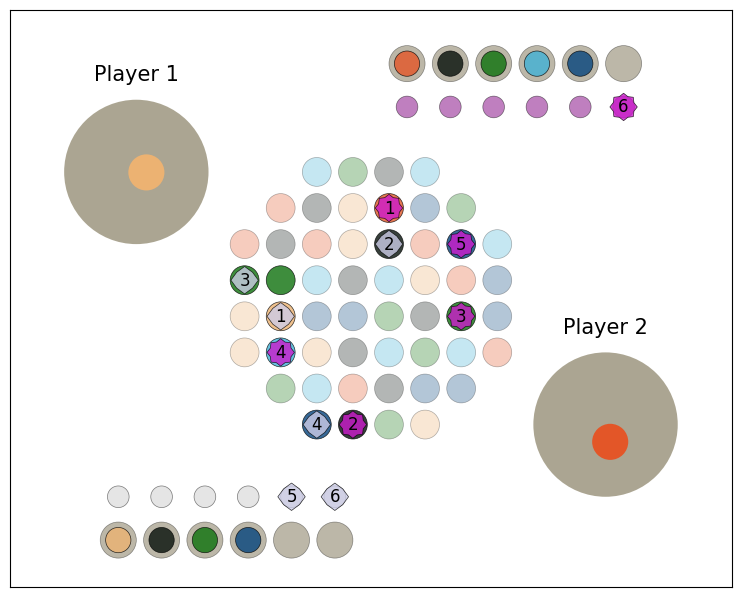

Turn 12, for Player 2
Score is currently:
Player 1: 15 -- 13: Player 2
Available actions are: 
[26, 22, 29, 25, 38, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 31, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 47, 51, 44, 78]
action taken is: 44
Color: 0
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (5, 5), (1, 1), (0, 3), (2, 0), (2, 3), (6, 6), (7, 5)}
Passive flipping groups: {(4, 0)}
Passive placing groups: {(4, 0), (4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(5, 3), (6, 2), (6, 4)}

Color: 2
Active flipping groups: set()
Active placing groups: {(6, 1), (5, 0), (5, 2)}

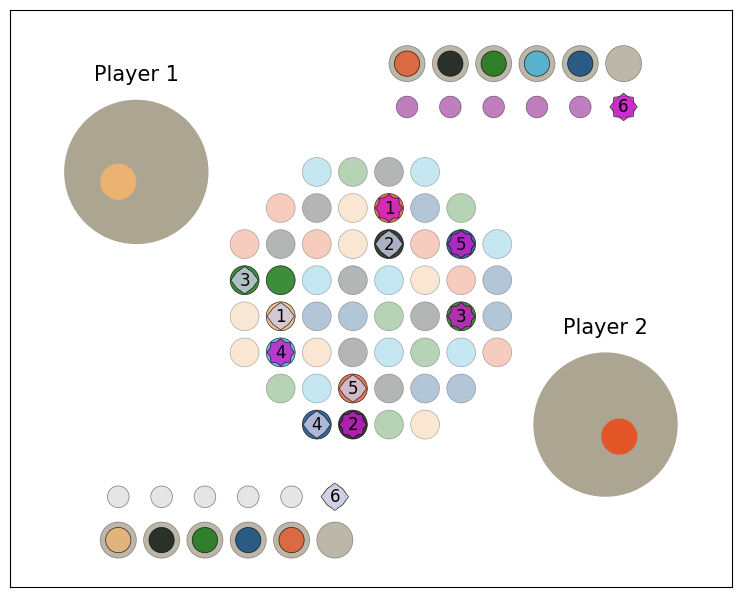

Turn 13, for Player 1
Score is currently:
Player 1: 15 -- 18: Player 2
Available actions are: 
[26, 22, 29, 25, 38, 41, 0, 3, 12, 9, 15, 6, 50, 43, 46, 28, 31, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 20, 33, 23, 36, 30, 39, 4, 1, 10, 13, 47, 51]
action taken is: 39
Color: 0
Active flipping groups: {(4, 0)}
Active placing groups: {(4, 0), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(4, 5), (5, 4), (5, 6), (6, 5)}

Color: 1
Active flipping groups: set()
Active placing groups: {(5, 3), (6, 2), (6, 4)}
Passive flipping groups: set()
Passive placing groups: {(1, 3), (1, 5), (0, 4)}

Color: 2
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 2), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (1, 1), (0, 3), (2, 0), (2, 3), (6, 6), (7, 5)}
Passive

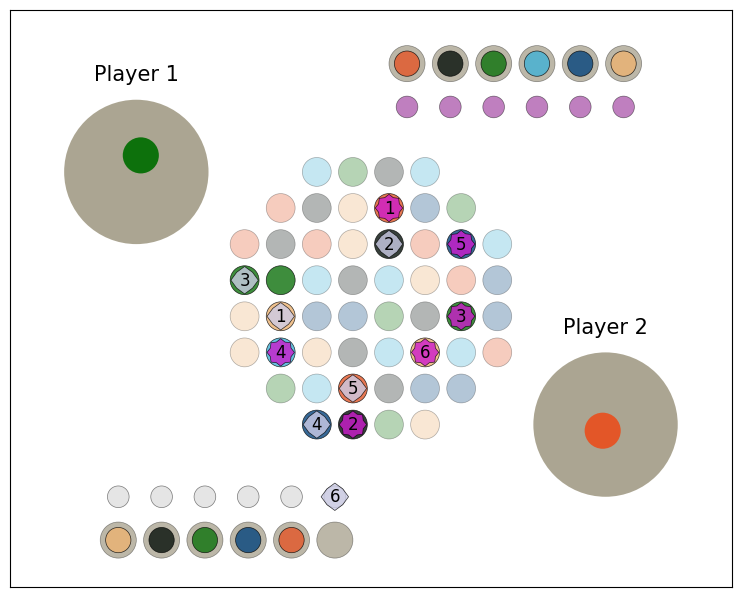

Turn 14, for Player 2
Score is currently:
Player 1: 21 -- 18: Player 2
Available actions are: 
[37, 43, 45, 78]
action taken is: 43
Color: 0
Active flipping groups: set()
Active placing groups: {(4, 5), (5, 4), (5, 6), (6, 5)}
Passive flipping groups: {(4, 0)}
Passive placing groups: {(4, 0), (4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(5, 3), (6, 1), (6, 4), (5, 2)}

Color: 2
Active flipping groups: set()
Active placing groups: {(6, 1), (5, 0), (5, 2)}
Passive flipping groups: set()
Passive placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 5), (4, 2), (4, 5), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (1, 1), (0, 3), (2, 0), (2, 3), (6, 6), (7, 5)}

Color: 3
Active flipping groups: set()
Active placing groups: {(7

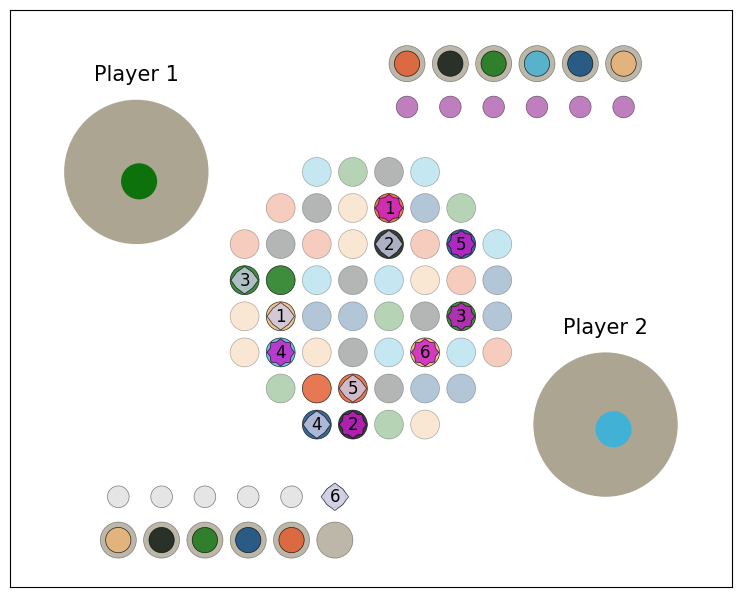

Turn 15, for Player 1
Score is currently:
Player 1: 21 -- 23: Player 2
Available actions are: 
[31, 40, 33, 24]
action taken is: 31
Color: 0
Active flipping groups: {(4, 0)}
Active placing groups: {(4, 0), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(5, 4), (5, 6), (6, 5)}

Color: 1
Active flipping groups: set()
Active placing groups: {(5, 3), (6, 1), (6, 4), (5, 2)}
Passive flipping groups: set()
Passive placing groups: {(1, 3), (1, 5), (0, 4)}

Color: 2
Active flipping groups: set()
Active placing groups: {(4, 0), (3, 4), (4, 3), (3, 7), (5, 4), (5, 7), (0, 2), (0, 5), (2, 2), (1, 6), (2, 5), (1, 3), (7, 4), (6, 5), (4, 2), (3, 3), (5, 0), (5, 6), (3, 6), (5, 3), (1, 2), (0, 4), (2, 1), (2, 7), (1, 5), (6, 1), (6, 4), (3, 2), (4, 7), (3, 5), (5, 2), (4, 4), (1, 1), (0, 3), (2, 0), (2, 3), (6, 6), (7, 5)}
Passive flipping groups: set()
Passive placing groups: {(6, 1), (5, 0), (5, 2)}

Color: 3
Active flipping groups: set()
Active placing groups: {(2, 3), (2, 5), (3

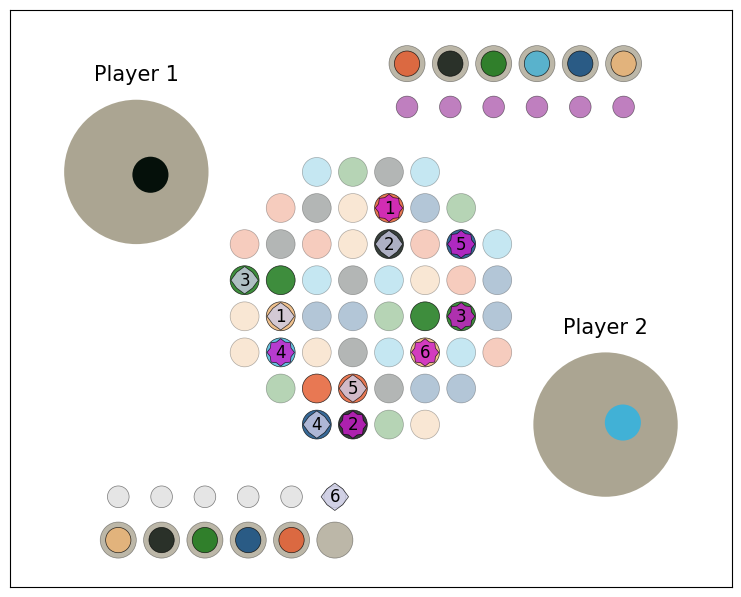

Turn 16, for Player 2
Score is currently:
Player 1: 24 -- 23: Player 2
Available actions are: 
[26, 22, 29, 25, 38, 41, 0, 3, 12, 9, 15, 6, 50, 46, 28, 21, 34, 40, 24, 37, 5, 2, 11, 17, 8, 42, 45, 20, 33, 23, 36, 30, 4, 1, 10, 13, 47, 51, 78]
action taken is: 33
Color: 0
Active flipping groups: set()
Active placing groups: {(5, 4), (5, 6), (6, 5)}
Passive flipping groups: {(4, 0)}
Passive placing groups: {(4, 0), (4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(5, 3), (6, 1), (6, 4), (5, 2)}

Color: 2
Active flipping groups: set()
Active placing groups: {(6, 1), (5, 0), (5, 2)}
Passive flipping groups: set()
Passive placing groups: {(3, 7), (5, 7)}

Color: 3
Active flipping groups: set()
Active placing groups: {(7, 4)}
Passive flipping groups: set()
Passive placing groups: {(2, 3), (2, 5), (3, 4)}

Color: 4
Active flipping groups: set()
Active placing groups: {(1, 6), (2, 5), (2, 7),

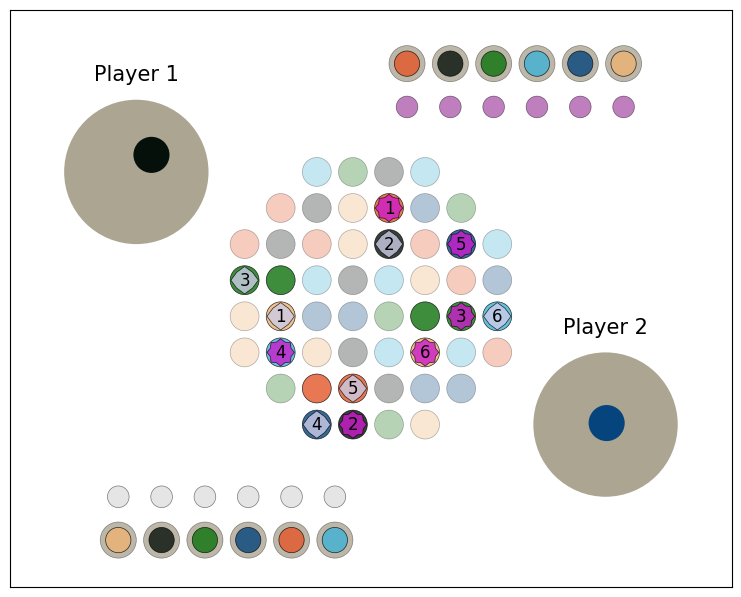

Turn 17, for Player 1
Score is currently:
Player 1: 24 -- 29: Player 2
Available actions are: 
[50, 82]
action taken is: 50
Color: 0
Active flipping groups: {(4, 0)}
Active placing groups: {(4, 0), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(5, 4), (5, 6), (6, 5)}

Color: 1
Active flipping groups: set()
Active placing groups: {(5, 3), (6, 1), (6, 4), (5, 2)}
Passive flipping groups: set()
Passive placing groups: {(1, 3), (1, 5), (0, 4)}

Color: 2
Active flipping groups: set()
Active placing groups: {(3, 7), (5, 7)}
Passive flipping groups: set()
Passive placing groups: {(6, 1), (5, 0), (5, 2)}

Color: 3
Active flipping groups: set()
Active placing groups: {(2, 3), (2, 5), (3, 4)}
Passive flipping groups: {(6, 4)}
Passive placing groups: {(7, 5), (6, 4)}

Color: 4
Active flipping groups: set()
Active placing groups: set()
Passive flipping groups: set()
Passive placing groups: {(1, 6), (2, 5), (2, 7), (3, 6)}

Color: 5
Active flipping groups: set()
Active placing gro

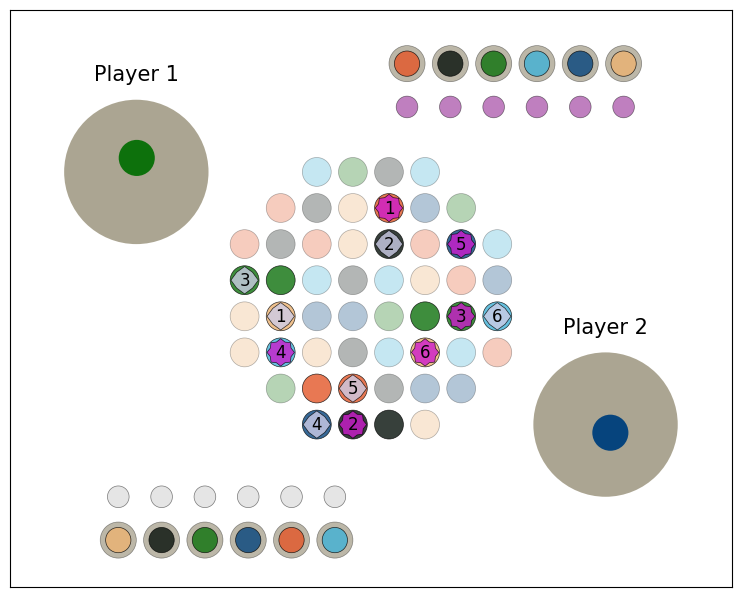

Turn 18, for Player 2
Score is currently:
Player 1: 26 -- 29: Player 2
Available actions are: 
[78]
###########################
ALERT: no more placing moves from now on!
###########################
action taken is: 78
Color: 0
Active flipping groups: set()
Active placing groups: {(5, 4), (5, 6), (6, 5)}
Passive flipping groups: {(5, 0)}
Passive placing groups: {(5, 0), (4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(5, 3), (6, 1), (6, 4), (5, 2)}

Color: 2
Active flipping groups: set()
Active placing groups: {(6, 1), (5, 0), (5, 2)}
Passive flipping groups: set()
Passive placing groups: {(3, 7), (5, 7)}

Color: 3
Active flipping groups: {(6, 4)}
Active placing groups: {(7, 5), (6, 4)}
Passive flipping groups: set()
Passive placing groups: {(2, 3), (2, 5), (3, 4)}

Color: 4
Active flipping groups: set()
Active placing groups: {(1, 6), (2, 5), (2, 7), (3, 6)}
Passive flipping groups: 

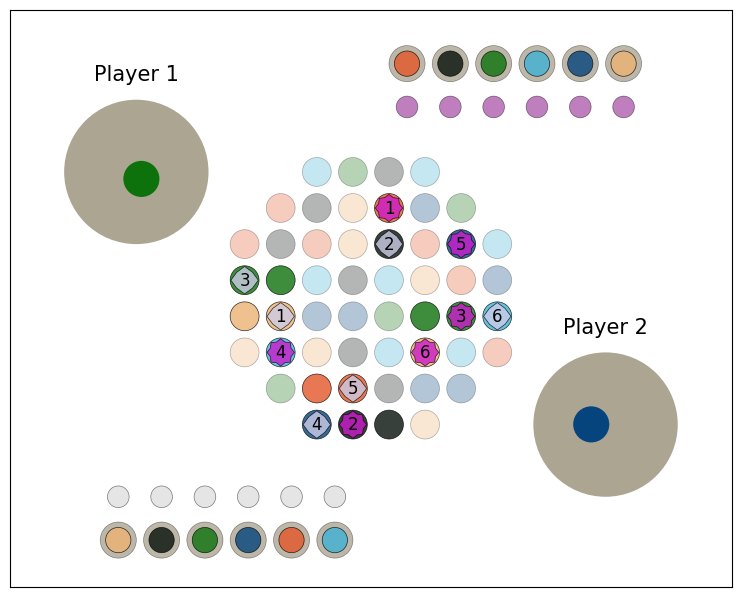

Turn 19, for Player 1
Score is currently:
Player 1: 26 -- 30: Player 2
Available actions are: 
[97, 82]
action taken is: 82
Color: 0
Active flipping groups: {(5, 0)}
Active placing groups: {(5, 0), (4, 2)}
Passive flipping groups: set()
Passive placing groups: {(5, 4), (5, 6), (6, 5)}

Color: 1
Active flipping groups: set()
Active placing groups: {(5, 3), (6, 1), (6, 4), (5, 2)}
Passive flipping groups: set()
Passive placing groups: {(1, 3), (1, 5), (0, 4)}

Color: 2
Active flipping groups: set()
Active placing groups: {(3, 7), (5, 7)}
Passive flipping groups: set()
Passive placing groups: {(6, 1), (5, 0), (5, 2)}

Color: 3
Active flipping groups: set()
Active placing groups: {(2, 3), (2, 5), (3, 4)}
Passive flipping groups: {(6, 4)}
Passive placing groups: {(7, 5), (6, 4)}

Color: 4
Active flipping groups: set()
Active placing groups: set()
Passive flipping groups: set()
Passive placing groups: {(1, 6), (2, 5), (2, 7), (3, 6)}

Color: 5
Active flipping groups: set()
Active placing gro

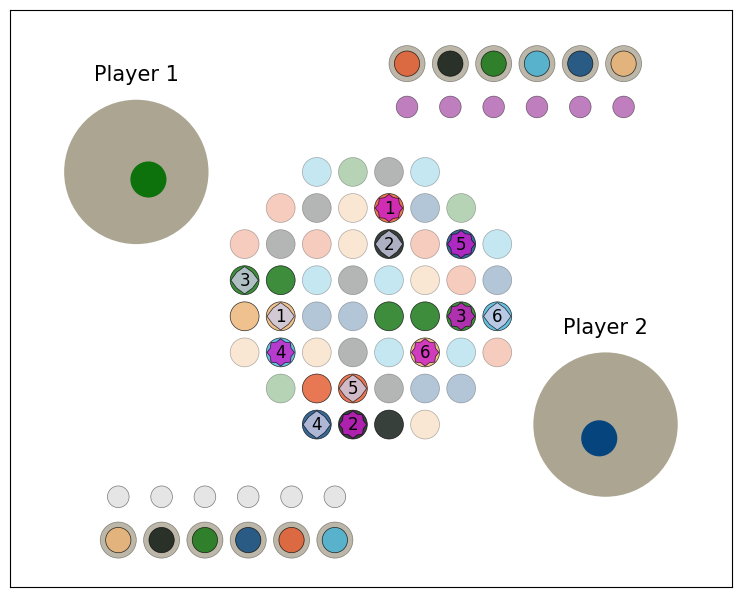

Turn 20, for Player 2
Score is currently:
Player 1: 29 -- 30: Player 2
Available actions are: 
[86]
action taken is: 86
Color: 0
Active flipping groups: set()
Active placing groups: {(5, 4), (5, 6), (6, 5)}
Passive flipping groups: set()
Passive placing groups: {(4, 2)}

Color: 1
Active flipping groups: set()
Active placing groups: {(1, 3), (1, 5), (0, 4)}
Passive flipping groups: set()
Passive placing groups: {(5, 3), (6, 1), (6, 4), (5, 2)}

Color: 2
Active flipping groups: set()
Active placing groups: {(6, 1), (5, 2)}
Passive flipping groups: set()
Passive placing groups: {(3, 7), (5, 7)}

Color: 3
Active flipping groups: {(6, 4)}
Active placing groups: {(7, 5), (6, 4)}
Passive flipping groups: set()
Passive placing groups: {(2, 3), (2, 5), (3, 4)}

Color: 4
Active flipping groups: set()
Active placing groups: {(1, 6), (2, 5), (2, 7), (3, 6)}
Passive flipping groups: set()
Passive placing groups: set()

Color: 5
Active flipping groups: set()
Active placing groups: {(4, 3), (5, 6), (

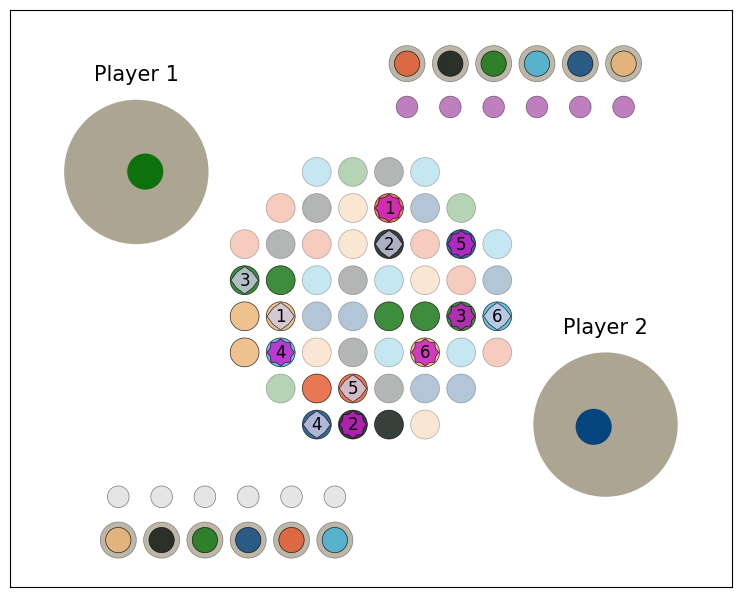

Turn 21, for Player 1
Score is currently:
Player 1: 29 -- 31: Player 2
Available actions are: 
[97]
action taken is: 97
Game finished! Result is: 0


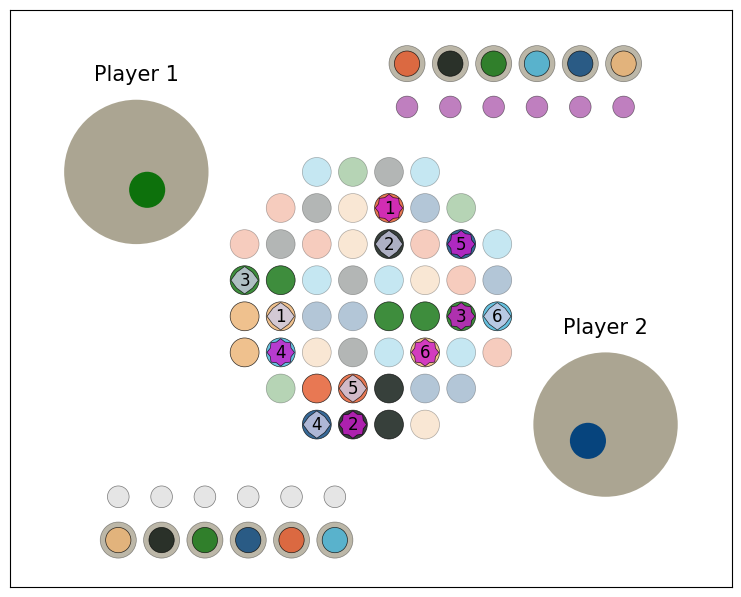

In [20]:
my_patterns = Patterns()
still_placing = True

while True:
    print(f"Turn {my_patterns.turn_number}, for Player {my_patterns.player + 1}")
    print(f"Score is currently:")
    active_score, passive_score = my_patterns.calculate_score()
    
    p1_score = active_score if my_patterns.player == 0 else passive_score
    p2_score = active_score if my_patterns.player == 1 else passive_score
    
    print(f"Player 1: {p1_score} -- {p2_score}: Player 2")
    
    actions = my_patterns.get_actions() 
    print(f"Available actions are: \n{actions}")
    
    if my_patterns.is_no_more_placing is True and still_placing is True:
        still_placing = False
        print(f"###########################")
        print(f"ALERT: no more placing moves from now on!")
        print(f"###########################")
        
    action = random.choice(actions)
    print(f"action taken is: {action}")
    is_terminal, _result = my_patterns.step(action)

    if is_terminal:
        break
        
    for _col in range(6):
        if (my_patterns.active_color_order[_col] > 0) or (my_patterns.passive_color_order[_col] > 0):
            print(f"Color: {_col}")
            print(f"Active flipping groups: {my_patterns.active_flipping_groups[_col]}")
            print(f"Active placing groups: {my_patterns.active_placing_groups[_col]}")
            print(f"Passive flipping groups: {my_patterns.passive_flipping_groups[_col]}")
            print(f"Passive placing groups: {my_patterns.passive_placing_groups[_col]}\n")
            
    pattern_plotter = PatternPlotter(my_patterns, fig_size=(10, 7.5))
    pattern_plotter.populate_board()

print(f"Game finished! Result is: {_result}")

pattern_plotter.populate_board()

In [ ]:
print()
print(my_patterns.player, my_patterns.active_board, my_patterns.active_bowl_token, )

actions = my_patterns.get_actions()

print(f"Available actions are: {actions}\n")

action = random.choice(actions)

print(f"action taken is: {action}\n")

my_patterns.step(action)

print(my_patterns.player, my_patterns.active_board, my_patterns.active_bowl_token)

pattern_plotter = PatternPlotter(my_patterns, fig_size=(10, 7.5))
pattern_plotter.populate_board()

In [21]:
def play_random_patterns(num_iterations: int) -> None:
    """ play a set number of random games
    """
    num_turns = [0] * num_iterations
    
    for it in range(num_iterations):
        patterns_game = Patterns()

        while True:
            actions = patterns_game.get_actions()
            action = random.choice(actions)
            is_terminal, result = patterns_game.step(action)
            
            if is_terminal:
                break
        num_turns[it] = patterns_game.turn_number

    return num_turns

In [7]:
_res = play_random_patterns(10000)

In [8]:
np.sum(_res) / 10000

32.3143

In [16]:
len({1, 2, 3})

3

In [22]:
%prun play_random_patterns(10000)


         8992575 function calls in 13.425 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   310031    2.457    0.000    2.457    0.000 game.py:298(remove_new_location)
   310031    1.847    0.000    2.364    0.000 game.py:316(update_placing_and_flipping_groups)
   323379    1.058    0.000    8.804    0.000 game.py:218(step)
   310031    0.869    0.000    6.814    0.000 game.py:275(update_locations)
   304052    0.848    0.000    0.848    0.000 game.py:191(<listcomp>)
   313379    0.740    0.000    0.740    0.000 game.py:202(swap_players)
   823379    0.700    0.000    0.930    0.000 random.py:235(_randbelow_with_getrandbits)
   323379    0.648    0.000    1.496    0.000 game.py:174(get_actions)
        1    0.630    0.630   13.425   13.425 888770904.py:1(play_random_patterns)
   310031    0.479    0.000    0.558    0.000 game.py:290(update_board)
   310031    0.470    0.000    0.566    0.000 game.py:306(update_color_groups

In [12]:
def test_set_minus(num_it):
    my_dict = {_num: set(range(100)) for _num in range(6)}

    for it in range(10000):
        for _col in range(6):
            my_dict[_col] -= {11}
            
def test_set_minus_2(num_it):
    my_dict = {_num: set(range(100)) for _num in range(6)}

    for it in range(10000):
        for _col in range(6):
            my_dict[_col] -= {11}

In [13]:
%prun test_set_minus(100000)

         5 function calls in 0.021 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.020    0.020    0.020    0.020 178923598.py:1(test_set_minus)
        1    0.000    0.000    0.021    0.021 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 178923598.py:2(<dictcomp>)
        1    0.000    0.000    0.020    0.020 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [14]:
%prun test_set_minus_2(100000)


         5 function calls in 0.021 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.021    0.021    0.021    0.021 178923598.py:8(test_set_minus_2)
        1    0.000    0.000    0.021    0.021 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 178923598.py:9(<dictcomp>)
        1    0.000    0.000    0.021    0.021 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [ ]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np

token_center = (0.0, 0.0)
outrad = 0.35
inrad = 0.28
num_points = 7
arc = 2. * np.pi / num_points

patch_coords_1 = [
    [token_center[0] + outrad * np.cos(arc * _it),
     token_center[1] + outrad * np.sin(arc * _it)]
    for _it in range(num_points)
]
                
patch_coords_2 = [
    [token_center[0] + inrad * np.cos((arc / 2) + arc * _it),
     token_center[1] + inrad * np.sin((arc / 2) + arc * _it)]
    for _it in range(num_points)
]

patch_coords = []
for p1, p2 in zip(patch_coords_1, patch_coords_2):
    patch_coords.append(p1)
    patch_coords.append(p2)
    
fig, ax = plt.subplots()
ax.add_patch(patches.Polygon(patch_coords, facecolor='red', edgecolor='black', linewidth=0.5))
# ax.add_patch(patches.Polygon(patch_coords_1))
# ax.add_patch(patches.Polygon(patch_coords_2))

ax.set_xlim([-2., 2.])
ax.set_ylim([-2., 2.])
ax.set_aspect('equal')

In [23]:
import torch
from torch import nn
import math

In [30]:

class BoardInitNet(nn.Module):
    """ initial CNN processing of the board representation:
    """
    def __init__(self,
                 in_channels: int = 3,
                 out_channels: int = 64,
                 ) -> None:
        super(BoardInitNet, self).__init__()

        self.init = nn.Sequential(
            # Gather all "local" information for each board spot (including stuff on top)
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.init(x)

In [32]:
my_net = BoardInitNet()
input_tensor = torch.tensor(np.random.rand(1, 3, 8, 8)).float()
my_net(input_tensor).shape

torch.Size([1, 64, 4, 4])

In [33]:
my_patterns.active_board


array([[ 0,  0,  2,  5,  3,  2,  0,  0],
       [ 0,  1,  3,  0,  7,  4,  5,  0],
       [ 1,  3,  1,  0, 15,  1, 10,  2],
       [17, 17,  2,  3,  2,  0,  1,  4],
       [12, 12,  4,  4, 11, 11, 11, 14],
       [12,  8,  0,  3,  2,  6,  2,  1],
       [ 0,  5, 13, 13,  9,  4,  4,  0],
       [ 0,  0, 16,  9,  9,  0,  0,  0]])

In [37]:
my_one_hot = torch.nn.functional.one_hot(torch.tensor(my_patterns.active_board).long(), num_classes=18)

In [44]:
torch.nn.functional.one_hot(torch.tensor(my_patterns.active_color_order).long() - 1, num_classes=6)


tensor([[0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0]])

In [49]:
my_tens = torch.empty((8, 8, 36), dtype=bool)
for _it, _order in enumerate(my_patterns.active_color_order):
    my_tens[:, :, _it * 6 + _order] = 1

my_tens.int().shape

torch.Size([8, 8, 36])

In [53]:
# the board is just a one hot encoded version of the numpy board:
board_tensor = torch.nn.functional.one_hot(torch.tensor(my_patterns.active_board).long(), num_classes=18)

# 36 channels for each player for color group: order mapping:
order_tensor = torch.empty((8, 8, 72), dtype=bool)
for _it, (active_order, passive_order) in enumerate(zip(my_patterns.active_color_order, my_patterns.passive_color_order)):
    order_tensor[:, :, _it * 6 + active_order] = 1
    order_tensor[:, :, 36 + _it * 6 + passive_order] = 1
    
# bowl tokens:
bowl_tensor = torch.empty((8, 8, 12), dtype=bool)
bowl_tensor[:, :, my_patterns.active_bowl_token] = 1
bowl_tensor[:, :, 6 + my_patterns.passive_bowl_token] = 1

newtens =  torch.cat([board_tensor, order_tensor, bowl_tensor], dim=-1)

In [54]:
newtens

tensor([[[1, 0, 0,  ..., 0, 1, 0],
         [1, 0, 0,  ..., 0, 1, 0],
         [0, 0, 1,  ..., 0, 1, 0],
         ...,
         [0, 0, 1,  ..., 0, 1, 0],
         [1, 0, 0,  ..., 0, 1, 0],
         [1, 0, 0,  ..., 0, 1, 0]],

        [[1, 0, 0,  ..., 0, 1, 0],
         [0, 1, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         ...,
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [1, 0, 0,  ..., 0, 1, 0]],

        [[0, 1, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 1, 0,  ..., 0, 1, 0],
         ...,
         [0, 1, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 1,  ..., 0, 1, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [1, 0, 0,  ..., 0, 1, 0],
         ...,
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 1,  ..., 0, 1, 0],
         [0, 1, 0,  ..., 0, 1, 0]],

        [[1, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0,

In [55]:
newtens.shape

torch.Size([8, 8, 102])

In [56]:
72 + 18 + 12

102

In [156]:
""" Value and Policy Neural Networks defined in PyTorch for use in the MCTS algorithm:

State input is 8x8x102, which completely describes the current markov state.

Note that if we ever move to using a transformer, it may not be necessary to continue storing the state in this way

We create a CNN for the board, and MLPs for the other states.

We want to munge the conv net on the board state and the state vectors early on...

For now, we do all the CNN resnet stuff, followed by the MLP fully connected layers
to blend the state with the image.
"""
import torch
from torch import nn
import math


class PatternsNet(nn.Module):
    """ Take in the initial munging of the board and player states, and perform standard resnet
    fun on it:
    """
    def __init__(self,
                 in_channels: int = 102,
                 out_channels: int = 64,
                 ) -> None:
        """ 102 in channels for patterns. 18 for color and player, 72 for color group order, 12 for bowl tokens.
         """
        super(PatternsNet, self).__init__()

        # initial processing layer: output size (samples, out_channels, 8, 8)
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Downsampling layers:
        self.down1 = ResidualLayer(in_channels=out_channels, stride=2)
        out_channels *= 2
        self.down2 = ResidualLayer(in_channels=out_channels, stride=2)
        out_channels *= 2

        # Standard resnet layers:
        self.standard1 = ResidualLayer(in_channels=out_channels, stride=1)
        self.standard2 = ResidualLayer(in_channels=out_channels, stride=1)

        # different heads:
        self.twoheadlayer = TwoHeadNet(in_channels=out_channels,
                                       value_out_channels=out_channels // 16,
                                       policy_out_channels=out_channels // 4,
                                       action_space=(106,))

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """ pass the input through the initial conv layer, expanding input channels to the number
        of filters required, before passing through the residual blocks """
        x = self.input_layer(x)
        x = self.down2(self.down1(x))
        x = self.standard2(self.standard1(x))

        return self.twoheadlayer(x)


class TwoHeadNet(nn.Module):
    """ Two different heads, attached to resnet backbone:

    One head addresses the policy prediction (with action-space number of neurons)
    one head addresses the value prediction (with a single neuron output, scaled to -1, 1
    """
    def __init__(self,
                 in_channels: int,
                 value_out_channels: int,
                 policy_out_channels: int,
                 action_space: tuple = (106,)) -> None:
        super(TwoHeadNet, self).__init__()
        self.action_space = action_space

        # output is float between -1 and 1 estimating board state
        self.value_head = nn.Sequential(
            # final bespoke convolutional layer for value:
            nn.Conv2d(in_channels, value_out_channels, kernel_size=3, padding=1, stride=1),# bias=False),
            nn.BatchNorm2d(value_out_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            # squash to flat:
            nn.Flatten(),
            nn.Linear(in_features=value_out_channels, out_features=1),
            # squish to between -1 and 1 to estimate the result of the game:
            nn.Tanh(),
        )

        # output is logits for softmax to give distribution over action space
        self.policy_head = nn.Sequential(
            nn.Conv2d(in_channels, policy_out_channels, kernel_size=3, padding=1, stride=1),# bias=False),
            nn.BatchNorm2d(policy_out_channels),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=policy_out_channels, out_features=math.prod(action_space)),
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """ produce both outputs """
        value_x = self.value_head(x)
        policy_x = self.policy_head(x).view((-1, *self.action_space))

        return value_x, policy_x


class ResidualLayer(nn.Module):
    """ Stick two residual basic blocks together, apply down-sampling as required:
    """
    def __init__(self,
                 in_channels: int = 128,
                 stride: int = 1) -> None:
        super(ResidualLayer, self).__init__()

        # The first block can be a down-sampling layer:
        self.basic_block_1 = ResidualBlock(in_channels=in_channels, stride=stride)
        self.basic_block_2 = ResidualBlock(in_channels=in_channels * stride, stride=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ basic_block_1 will return x + conv(x)
        """
        x1 = self.basic_block_1(x)
        return self.basic_block_2(x1)


class ResidualBlock(nn.Module):
    """ A residual block of a resnet.

    Note that channels in and out are assumed equal, to allow for addition with manipulation.
    """
    def __init__(self,
                 in_channels: int,
                 stride: int = 1) -> None:
        super(ResidualBlock, self).__init__()

        self.is_downsample = True if stride != 1 else False

        out_channels = stride * in_channels

        # first layer can be downsample:
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        # if downsampling, also downsample the residual for consistent tensor size:
        if self.is_downsample:
            # skip block needs a 1x1 conv to increase in channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ conv block applied to x, with skip connection to allow for robust residual training """
        residual = x if not self.is_downsample else self.downsample(x)
        return self.relu(residual + self.conv_2(self.conv_1(x)))


In [157]:
def get_tensor_state(game) -> torch.Tensor:
    """ Use the game state to form a torch tensor that can be used to eval the position

    Currently, the history is not included, but it might be in the future.

    The tensor state is 8 x 8 x (6x3 + 6x6 + 6x6 + 2x6) binary tensor.

    The first 6x3 planes represent the board itself, with planes 0-5 denoting the presence of an unflipped token
    of that color, 6-11 representing flipped for active player of that color, and 12-17 flipped for passive player.

    This matches the numpy array, one-hot-encoded.

    The next 2x6x6 planes represent the color group order taken, for each player.

    In particular, these planes are constant 1 or constant 0.
    Planes 0-5 represent the order at which color 0 was taken for the active player
    Planes 6-11 represent the order at which color 1 was taken for the active player etc.

    Planes 36 - 41 represent the order at which color 0 was taken for the passive player.
    Planes 42 - 47 represent the order at which color 1 was taken for the passive player etc.

    Finally, the final 12 planes represent the color of the bowl token for the active player (0-5) and the
    passive player (6-11).
    """
    # the board is just a one hot encoded version of the numpy board:
    board_tensor = torch.nn.functional.one_hot(torch.tensor(game.active_board).long(), num_classes=18)

    # 36 channels for each player for color group: order mapping:
    order_tensor = torch.zeros((8, 8, 72), dtype=bool)
    for _it, (active_order, passive_order) in enumerate(zip(game.active_color_order, game.passive_color_order)):
        if active_order > 0:
            order_tensor[:, :, _it * 6 + active_order - 1] = 1

        if passive_order > 0:
            order_tensor[:, :, 36 + _it * 6 + passive_order - 1] = 1

    # bowl tokens:
    bowl_tensor = torch.zeros((8, 8, 12), dtype=bool)
    bowl_tensor[:, :, game.active_bowl_token] = 1
    bowl_tensor[:, :, 6 + game.passive_bowl_token] = 1
    concat_tensor = torch.cat([board_tensor, order_tensor, bowl_tensor], dim=-1)

    return concat_tensor.permute(2, 0, 1)


In [158]:
my_tens = get_tensor_state(my_patterns)
device = torch.device('cuda')
pnet = PatternsNet()
pnet.to(device)
my_tens = my_tens.to(device).float()


In [164]:
out1 = pnet.input_layer(my_tens[None])
out2 = pnet.down1(out1)
out3 = pnet.down2(out2)
out4 = pnet.standard1(out3)
out5 = pnet.standard2(out4)
out6 = pnet.twoheadlayer(out5)

In [166]:
out1.shape, out2.shape, out3.shape, out4.shape, out5.shape, out6[0].shape, out6[1].shape

(torch.Size([1, 64, 8, 8]),
 torch.Size([1, 128, 4, 4]),
 torch.Size([1, 256, 2, 2]),
 torch.Size([1, 256, 2, 2]),
 torch.Size([1, 256, 2, 2]),
 torch.Size([1, 1]),
 torch.Size([1, 106]))

In [106]:
# the board is just a one hot encoded version of the numpy board:
board_tensor = torch.nn.functional.one_hot(torch.tensor(my_patterns.active_board).long(), num_classes=18)

# 36 channels for each player for color group: order mapping:
order_tensor = torch.zeros((8, 8, 72), dtype=bool)
for _it, (active_order, passive_order) in enumerate(zip(my_patterns.active_color_order, my_patterns.passive_color_order)):
    if active_order > 0:
        order_tensor[:, :, _it * 6 + active_order - 1] = 1

    if passive_order > 0:
        order_tensor[:, :, 36 + _it * 6 + passive_order - 1] = 1

# bowl tokens:
bowl_tensor = torch.zeros((8, 8, 12), dtype=bool)
bowl_tensor[:, :, my_patterns.active_bowl_token] = 1
bowl_tensor[:, :, 6 + my_patterns.passive_bowl_token] = 1

concat_tensor = torch.cat([board_tensor, order_tensor, bowl_tensor], dim=-1)

In [81]:
my_patterns.active_bowl_token, my_patterns.passive_bowl_token

(5, 4)

In [126]:
bowl_tensor[:, :, -1]

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])

In [105]:
my_tensor = torch.zeros((2, 3, 4), dtype=int)
my_tensor[:, :, 0]

tensor([[0, 0, 0],
        [0, 0, 0]])

In [115]:
my_patterns.active_color_order


[6, 1, 4, 2, 5, 3]